In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('november_2024_data.csv')
data.head()

,date,client,triggers,retriggers,notifications,component1,component2,component3
0,20241101,c1,1,10,11,2,0,9
1,20241101,c2,3,15,18,6,0,12
2,20241101,c3,2,1,3,2,1,0
3,20241101,c4,3,13,16,0,3,13
4,20241101,c5,1,3,4,1,2,1


In [13]:
# Function to load data with date range control
def load_data_with_date_range(file_path, start_date=None, end_date=None):
    # Load the data
    df = pd.read_csv(file_path)
    
    # Convert 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    
    # Filter by date range if specified
    if start_date:
        start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
        df = df[df['date'] >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date, format='%Y-%m-%d')
        df = df[df['date'] <= end_date]
    
    return df

# Example usage: Load data for November 15-20, 2024
output_file = "november_2024_data.csv"
filtered_data = load_data_with_date_range(output_file, start_date="2024-11-15", end_date="2024-11-20")

In [14]:
filtered_data.dtypes

date             datetime64[ns]
client                   object
triggers                  int64
retriggers                int64
notifications             int64
component1                int64
component2                int64
component3                int64
dtype: object

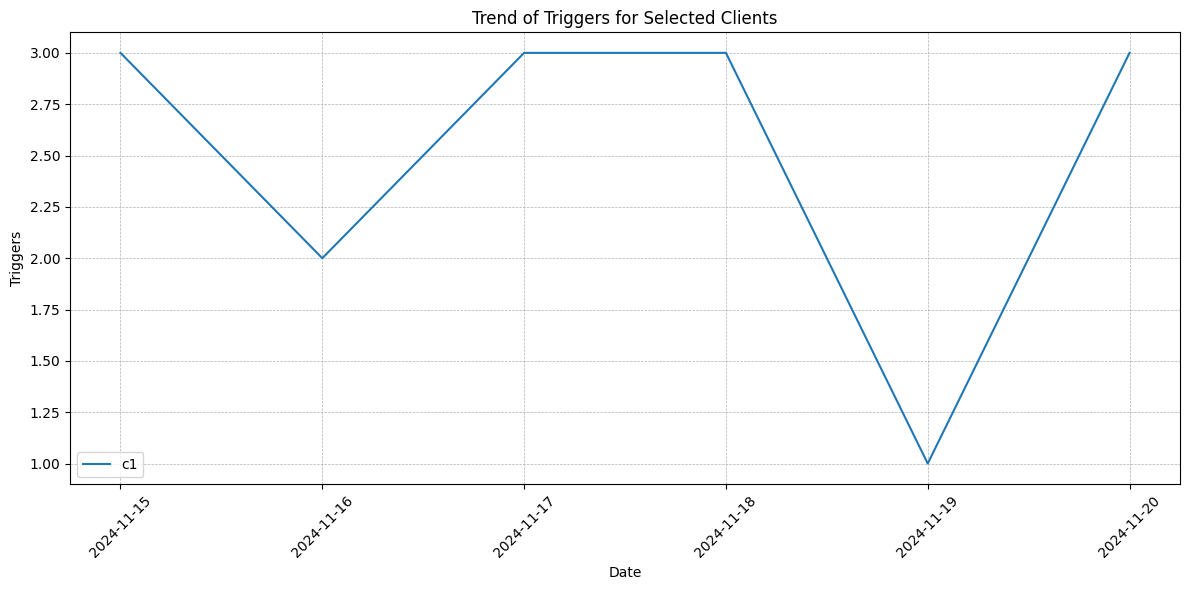

In [15]:
# Question 1: Trend of triggers per client in the given time frame
def plot_selected_triggers_trend(data, selected_clients):
    triggers_trend = data.groupby(["date", "client"])["triggers"].sum().reset_index()
    plt.figure(figsize=(12, 6))
    for client in selected_clients:
        client_data = triggers_trend[triggers_trend["client"] == client]
        plt.plot(client_data["date"], client_data["triggers"], label=client)
    plt.xlabel("Date")
    plt.ylabel("Triggers")
    plt.title("Trend of Triggers for Selected Clients") 
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example: Display trend for specific clients (e.g., "c1", "c3", "c5")
plot_selected_triggers_trend(filtered_data, ["c1"])

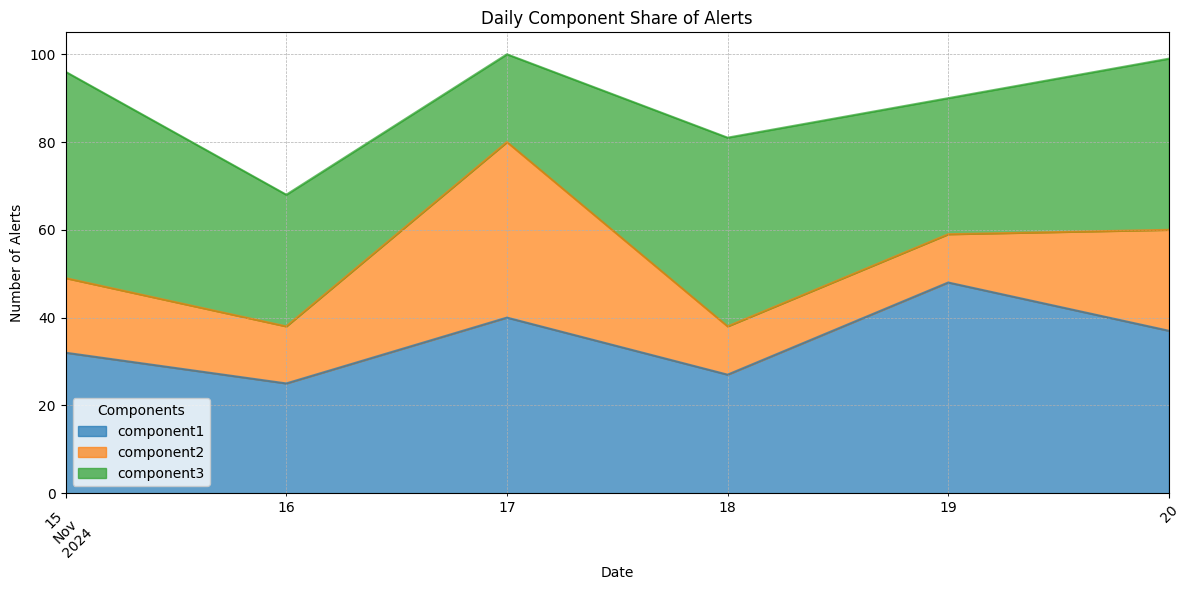

In [16]:
# Question 2: Component share of alerts every day with gridlines
def plot_component_share_with_grid(data):
    daily_components = data.groupby("date")[["component1", "component2", "component3"]].sum()
    daily_components.plot(kind="area", figsize=(12, 6), stacked=True, alpha=0.7)
    plt.title("Daily Component Share of Alerts")
    plt.xlabel("Date")
    plt.ylabel("Number of Alerts")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(rotation=45)
    plt.legend(title="Components")
    plt.tight_layout()
    plt.show()

plot_component_share_with_grid(filtered_data)

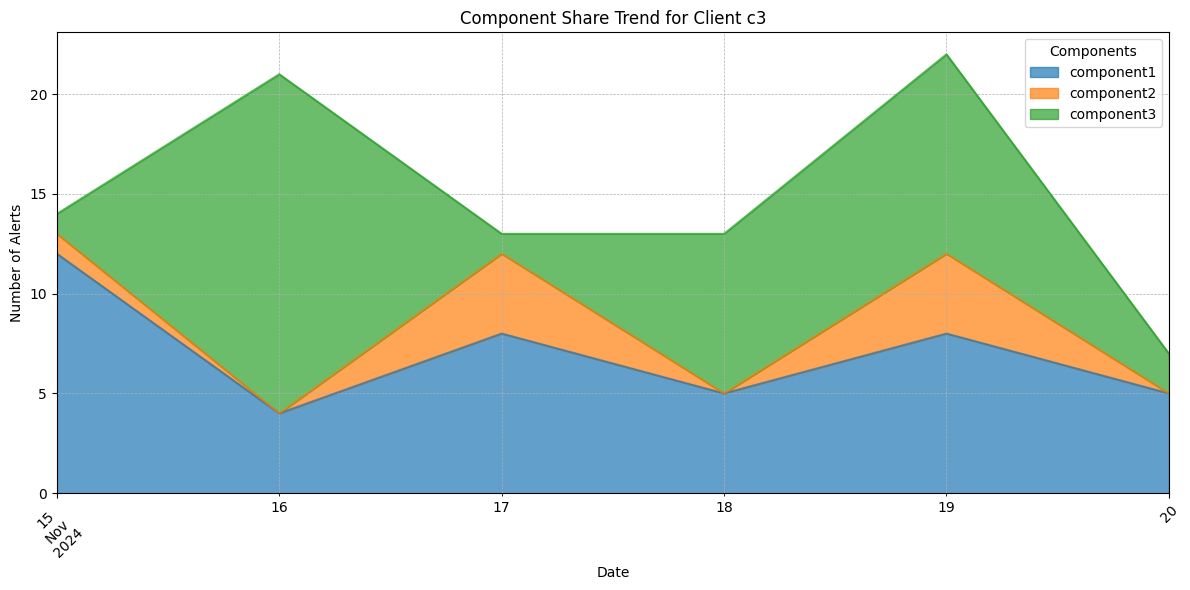

In [17]:
# Question 3: Trend of component share for a given client with gridlines
def plot_client_component_trend_with_grid(data, client):
    client_data = data[data["client"] == client]
    client_components = client_data.groupby("date")[["component1", "component2", "component3"]].sum()
    client_components.plot(kind="area", figsize=(12, 6), stacked=True, alpha=0.7)
    plt.title(f"Component Share Trend for Client {client}")
    plt.xlabel("Date")
    plt.ylabel("Number of Alerts")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(rotation=45)
    plt.legend(title="Components")
    plt.tight_layout()
    plt.show()  

# Example for a given client (e.g., "c3")
plot_client_component_trend_with_grid(filtered_data, "c3")

In [18]:
from datetime import datetime

def generate_metric_summary(data, client, start_date, end_date):
    # Filter data for the client and date range
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
    client_data = data[(data['client'] == client) & (data['date'] >= start_date) & (data['date'] <= end_date)]
    
    # Calculate totals for the start and end periods
    start_data = client_data[client_data['date'] == client_data['date'].min()]
    end_data = client_data[client_data['date'] == client_data['date'].max()]
    
    if start_data.empty or end_data.empty:
        return f"No data available for client {client} between {start_date} and {end_date}."
    
    start_totals = start_data[['triggers', 'retriggers', 'notifications']].sum()
    end_totals = end_data[['triggers', 'retriggers', 'notifications']].sum()
    
    # Calculate percentage changes
    changes = ((end_totals - start_totals) / start_totals) * 100
    changes = changes.fillna(0)  # Handle division by zero
    
    # Generate a summary
    story = f"""
    For client {client}, between {start_date.strftime('%Y-%m-%d')} and {end_date.strftime('%Y-%m-%d')}:
    - Triggers {('increased' if changes['triggers'] > 0 else 'decreased')} by {abs(changes['triggers']):.2f}%.
    - Retriggers {('increased' if changes['retriggers'] > 0 else 'decreased')} by {abs(changes['retriggers']):.2f}%.
    - Notifications {('increased' if changes['notifications'] > 0 else 'decreased')} by {abs(changes['notifications']):.2f}%.
    
    This indicates that {'the system has been experiencing more recurring issues' if changes['retriggers'] > 0 else 'the system is resolving issues more efficiently'}.
    """
    
    return story.strip()

# Example usage
start_date = datetime(2024, 11, 1)
end_date = datetime(2024, 11, 30)
summary = generate_metric_summary(filtered_data, client="c2", start_date=start_date, end_date=end_date)

# Display the summary
print(summary)


For client c2, between 2024-11-01 and 2024-11-30:
    - Triggers increased by 100.00%.
    - Retriggers increased by 72.73%.
    - Notifications increased by 75.00%.
    
    This indicates that the system has been experiencing more recurring issues.


In [23]:
from jinja2 import Template

# Example metrics
metrics = {
    "client": "c1",
    "start_date": "2024-11-15",
    "end_date": "2024-11-20",
    "triggers_change": -10.5,
    "retriggers_change": 15.3,
    "notifications_change": 4.5,
}

# Jinja2 Template for the summary
template = Template("""
Between {{ start_date }} and {{ end_date }}, client {{ client }} experienced a
{{ "decrease" if triggers_change < 0 else "increase" }} of {{ triggers_change | abs }}% in triggers,
a {{ "decrease" if retriggers_change < 0 else "increase" }} of {{ retriggers_change | abs }}% in retriggers,
and a {{ "decrease" if notifications_change < 0 else "increase" }} of {{ notifications_change | abs }}% in notifications.
This suggests {{ "fewer initial issues but a rise in recurring problems" if retriggers_change > 0 and triggers_change < 0 else "other trends requiring further analysis" }}.
""")

# Generate the summary
summary = template.render(**metrics)
print(summary)



Between 2024-11-15 and 2024-11-20, client c1 experienced a
decrease of 10.5% in triggers,
a increase of 15.3% in retriggers,
and a increase of 4.5% in notifications.
This suggests fewer initial issues but a rise in recurring problems.


In [25]:
def generate_summary(metrics):
    summary = (
        f"Between {metrics['start_date']} and {metrics['end_date']}, "
        f"client {metrics['client']} experienced a "
        f"{'decrease' if metrics['triggers_change'] < 0 else 'increase'} "
        f"of {abs(metrics['triggers_change']):.1f}% in triggers, a "
        f"{'decrease' if metrics['retriggers_change'] < 0 else 'increase'} "
        f"of {abs(metrics['retriggers_change']):.1f}% in retriggers, and a "
        f"{'decrease' if metrics['notifications_change'] < 0 else 'increase'} "
        f"of {abs(metrics['notifications_change']):.1f}% in notifications. "
        f"This suggests that "
        f"{'fewer initial issues but recurring problems' if metrics['retriggers_change'] > 0 and metrics['triggers_change'] < 0 else 'further investigation may be needed'}."
    )
    return summary

# Example metrics
metrics = {
    "client": "c1",
    "start_date": "2024-11-15",
    "end_date": "2024-11-20",
    "triggers_change": -10.5,
    "retriggers_change": 15.3,
    "notifications_change": 4.5,
}

# Generate the summary
print(generate_summary(metrics))


Between 2024-11-15 and 2024-11-20, client c1 experienced a decrease of 10.5% in triggers, a increase of 15.3% in retriggers, and a increase of 4.5% in notifications. This suggests that fewer initial issues but recurring problems.


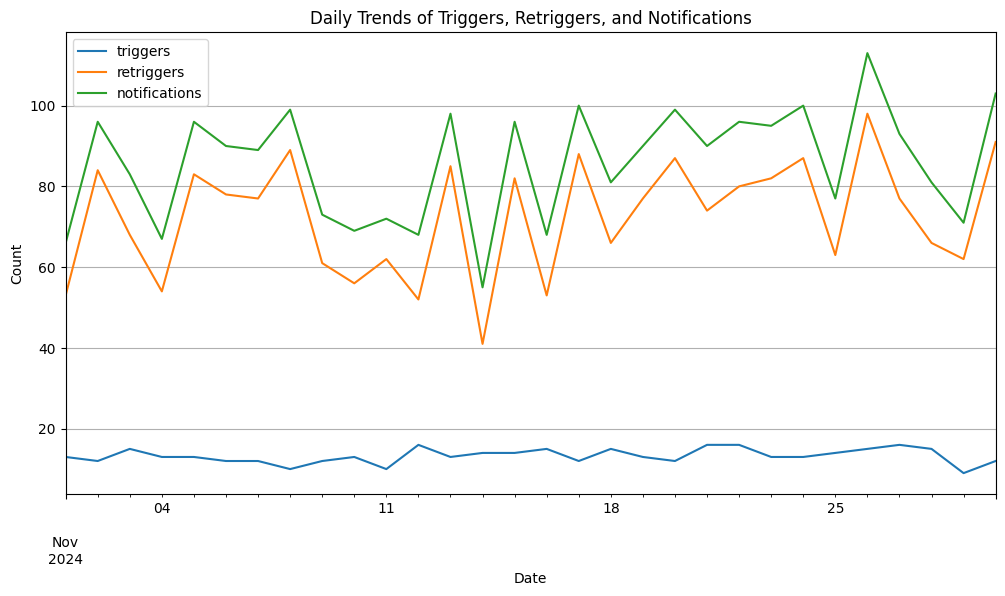

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'date' column to a datetime object for better analysis
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# Overall trends for triggers, retriggers, and notifications over time
daily_trends = data.groupby('date').sum()[['triggers', 'retriggers', 'notifications']]
daily_trends.plot(figsize=(12, 6), title="Daily Trends of Triggers, Retriggers, and Notifications")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid()
plt.show()

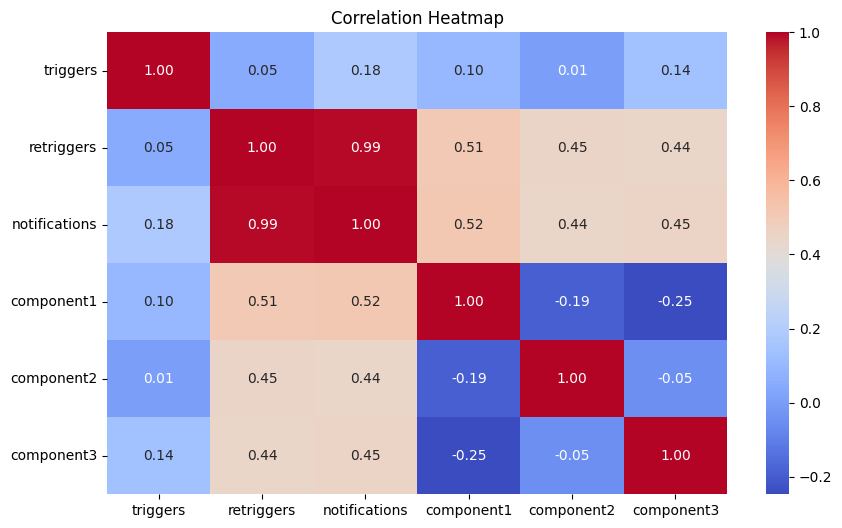

In [27]:
# Overall summary statistics
summary_stats = data.describe()

# Correlation analysis
correlation_matrix = data.drop(columns=['client', 'date']).corr()

# Plotting correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

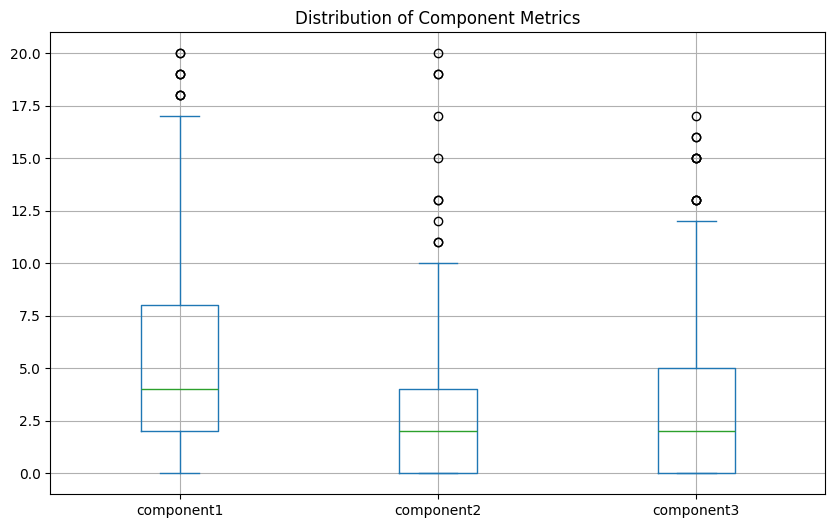

In [28]:
# Distribution of component metrics
component_metrics = data[['component1', 'component2', 'component3']]
component_metrics.plot(kind='box', figsize=(10, 6), title="Distribution of Component Metrics")
plt.grid()
plt.show()

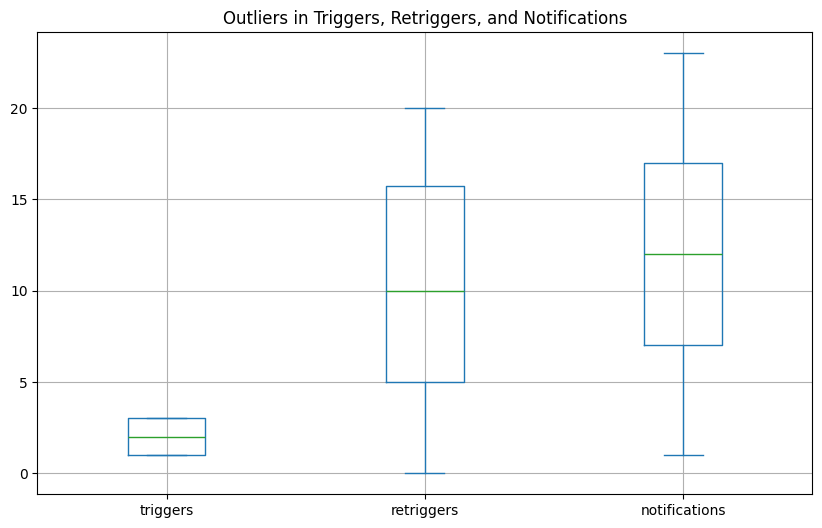

In [29]:
# Outlier detection using box plots for triggers, retriggers, and notifications
data[['triggers', 'retriggers', 'notifications']].plot(kind='box', figsize=(10, 6), title="Outliers in Triggers, Retriggers, and Notifications")
plt.grid()
plt.show()